## Bayesian Model Calibration and p-Values
We employed a linear quasi-static linear elastic model to help determine the timing of fracture events in our data.  When this model can accurately capture the observed ice behavior of the ice, it is unlikely that fracture events or other nonlinear mechanical behavior has occurred.   This notebook provides an implementation of our model, an approach for calibrating the model to observational data, and code for statistically assessing how well the model captures the observational data using a Bayesian generalization of classic p-value tests. 

## Imports 
The finite element model we employ is implemented with the [Fenics](https://fenicsproject.org/) package.  We also use scipy, numpy, and the scikit-learn package.  Fenics uses petsc behind the scenes for linear algebra.

In [1]:
import dolfin as dl
import mshr

import numpy as np
import scipy.linalg as la

from scipy import interpolate
import scipy.stats as stats

from matplotlib import pyplot as plt

from petsc4py import PETSc
from sklearn.metrics import pairwise_distances


### Read in coordinates defining the FYI-MYI boundary
The ICEX camp was on the edge of multiyear ice (MYI) and first year ice (FYI).  Here we read in the  digitized the coordinates of the MYI-FYI edge.

In [2]:
bndryCoords = np.genfromtxt('MY_boundary_coords.csv', delimiter=',')[1:,2:4]

### Read in the observed displacements
In our linear-elastic analysis, we are concerned with two different time periods: Mar. 9 08:34 through Mar. 9 1600 and Mar. 10 00:37 through Mar. 12 16:48.   Here we read in the observed displacements over one of these two time periods.  Reflectors without observations are ignored.

In [3]:
#dateStr = '_9Mar_0834_1600'
dateStr = '_10Mar_0037_12Mar_1648'
obsPos = np.genfromtxt('ReflDispl%s.csv'%dateStr,delimiter=',')[1:,1:]

obsLoc = np.vstack([obsPos[:,2:4], np.array([[0.0,0.0]])])
obsDisp = np.vstack([obsPos[:,2:4]-obsPos[:,0:2], np.array([[0.0,0.0]])])

nanBool = np.any(np.isnan(obsDisp), axis=1)

# The observed locations and displacements of the reflectors
obsLoc = obsLoc[~nanBool,:]
obsDisp = obsDisp[~nanBool,:]

# Finite Element Model Definition
### Define the Finite Element Mesh
We will later want to extract degrees of freedom along the FY-MY boundary.  We therefore use `mshr` to created a mesh where nodes along the MYI-FYI interface are maintained.

In [4]:
xmin, xmax = np.min(bndryCoords[:,0]), np.max(bndryCoords[:,0]) # Horizontal (east-west) extent of domain in meters
ymin, ymax = -915, 700 # Vertical (north-south) extent of domain in meters

Nx, Ny = 100,100 # Number of grid cells in horizontal and vertical directions

In [5]:
bbox = mshr.Rectangle(dl.Point(xmin,ymin), dl.Point(xmax,ymax))

pts_fy = [dl.Point(xmin,ymin), dl.Point(xmax,ymin)] + [dl.Point(pt[0],pt[1]) for pt in bndryCoords[::-1,:]]
poly_fy = mshr.Polygon(pts_fy)

bbox.set_subdomain(1, poly_fy)

mesh = mshr.generate_mesh(bbox, 50)

Now plot the mesh and the subdomains to visually verify everything worked.

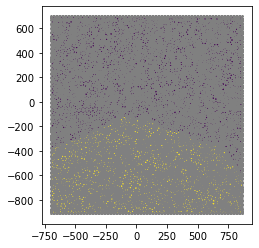

In [6]:
dl.plot(mesh)

cf = dl.MeshFunction("size_t", mesh, 2, mesh.domains())
dl.plot(cf)

plt.show()

### Define the ice mechanical properties

In [7]:
thick_fy = 1 # Thickness of first year ice in meters
thick_my = 4 # Thickness of multiyear ice in meters

youngsModulus_fy = 6e9 # Young's modulus for first year ice [Pascals]
youngsModulus_my = 9e9 # Young's modulus for multiyear ice [Pascals]

poissonRatio = 0.3 # Poisson ratio for all ice

Using the prescribed Young's modulus and Poisson ratio, we can now compute the Lam&#233; parameters for the FY and MY ice types.

In [8]:
lmbda_fy = youngsModulus_fy*poissonRatio/((1.0+poissonRatio)*(1.0-2.0*poissonRatio))
mu_fy    = youngsModulus_fy/(2.0*(1.0+poissonRatio))

lmbda_my = youngsModulus_my*poissonRatio/((1.0+poissonRatio)*(1.0-2.0*poissonRatio))
mu_my    = youngsModulus_my/(2.0*(1.0+poissonRatio))

The following classes defines the spatially varying Lame parameters used later on in the weak form.

In [9]:
class IceProperty(dl.UserExpression):
    """ Defines a property of the ice (like a Lame parameter) 
        that depends on whether the ice is first year ice or 
        multiyear ice.  The value of the parameter within each 
        ice type is constant.
    """
    
    def __init__(self, bndryCoords, val_fy, val_my, **kwargs):
        """
        Args:
            bndryCoords (np.array): A two column numpy array containing
                                    points on the boundary between first 
                                    year and multiyear ice.  This class 
                                    assumes that ice below this boundary 
                                    is first year and ice above this boundary
                                    is multiyear.  In the future, a more
                                    flexible definition of FY and MY domains
                                    might be necessary.
            val_fy (float): The value of the ice property for FY ice.
            val_my (float): The value of the ice property for MY ice.
            
        """
        super().__init__(**kwargs)
        self.bndryCoords = bndryCoords
        self.val_fy = val_fy
        self.val_my = val_my
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def eval(self, value, x):
        
        # First, figure out if we're below or about the FY-MY boundary
        bndry_y = self.bndryInterp(x[0])
        
        # The point is below the boundary, so use the FY value
        if(x[1]<bndry_y):
            value[0] = self.val_fy
        else:
            value[0] = self.val_my


### Set up the variational problem
In a three dimensional setting, the stress $\sigma$ is a second order tensor (i.e., matrix) in $\mathbb{R}^{3\times 3}$:  

\begin{equation}
\sigma(x) = \left[ \begin{array}{ccc} \sigma_{xx} & \sigma_{xy} & \sigma_{xz}\\ \sigma_{yx} & \sigma_{yy} & \sigma_{yz} \\ \sigma_{zx} & \sigma_{zy} & \sigma_{zz} \end{array}\right]
\end{equation}

For a linear elastic material, Hooke's law provides a general stress-strain relationship of the form:

\begin{equation}
\sigma = C : \varepsilon,
\end{equation}

where $\varepsilon\in\mathbb{R}^{3\times 3}$ is the second order stress tensor and $C$ is a fourth order symmetric stiffness tensor.  Under the additional assumption that the material is isotropic, the stiffness tensor $C$ can be completely defined in terms of the two Lam\'e parameters, $\lambda \in \mathbb{R}$ and $\mu\in\mathbb{R}$, and the tensor product $C : \varepsilon(x)$ becomes simply

\begin{equation}
\sigma= 2\mu\varepsilon + \lambda \text{tr}(\varepsilon) I. \label{eq:constitutive}
\end{equation}

Combining this expression with conservation of momentum and the small strain assumption, we obtain the classic static linear-elastic continuum model in 3D:

\begin{eqnarray}
-\nabla\cdot \sigma &=& f\label{eq:conservation}\\
\sigma&=& 2\mu\varepsilon + \lambda \text{tr}(\varepsilon) I\\
\varepsilon &=& \frac{1}{2}\left(\nabla u + \nabla u^T \right). \label{eq:smallstrain}
\end{eqnarray}


Our goal is to use the linear elastic equations above in a finite element method to model ice deformation. The thickness of the ice however is small relative to the horizontal extent of the domains we are interested in.   This suggests that we could reduce the computational expense of a full 3D simulation by approximating the ice deformation under a 2D plane stress formulation.  In this formulation, we assume the displacements and strains are constant in $z$ and that all $z$ components of the stress tensor are zero.    Under these assumptions, we can effectively ignore the $z$ terms and focus solely on modeling displacements in the $xy$-plane.   However, in this 2D approximation, we need to account for the changes in ice thickness between the FYI and MYI.  Let $h(x)$ denote the ice thickness.   The conservation equation then becomes becomes 

\begin{equation}
-\nabla \cdot(\tilde{\sigma} h) = f,
\end{equation}

where $\tilde{\sigma}$ is the two dimensional stress tensor

\begin{equation}
\tilde{\sigma} = \left[ \begin{array}{cc} \sigma_{xx} & \sigma_{xy} \\ \sigma_{yx} & \sigma_{yy} \end{array} \right].
\end{equation}



In [13]:
# Define the necessary function space
V = dl.FunctionSpace(mesh, "Lagrange", 1) # scalar function space
W = dl.VectorFunctionSpace(mesh, "Lagrange", 1) # vector function space
S = dl.TensorFunctionSpace(mesh, "DG", 0) # tensor function space

# Define measures of exterior boundaries
ds = dl.Measure("ds", domain=mesh, subdomain_data=boundaries)

# Trial functions
u = dl.TrialFunction(W) # displacement

# Test functions
w = dl.TestFunction(W)

# Total strain
eps = dl.sym(dl.grad(u))

# Spatially varying ice properties: Lame parameters and thickness
lbda  = IceProperty(bndryCoords=bndryCoords, val_fy=lmbda_fy, val_my=lmbda_my)
mu    = IceProperty(bndryCoords=bndryCoords, val_fy=mu_fy, val_my=mu_my)
thick = IceProperty(bndryCoords=bndryCoords, val_fy=thick_fy, val_my=thick_my)

# Stress
sigma = lbda*dl.Identity(2)*dl.tr(eps) + 2*mu*eps

# Linear elastic weak form -- comes from conservation equations
G = dl.inner(dl.grad(w), thick*sigma)*dl.dx

### Plot the spatially varying mechanical properties 

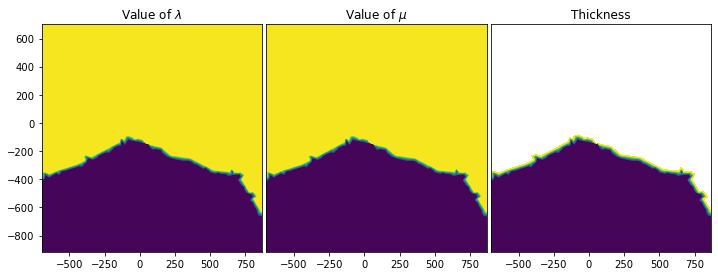

In [51]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6),sharey=True)

lbda_func = dl.interpolate(lbda,V)

# Lame 1
ax1 = plt.subplot(1, 3, 1)
dl.plot(lbda_func, title='Value of $\lambda$')

# Lame 2
plt.subplot(1, 3, 2, yticks=[])
mu_func = dl.interpolate(mu,V)
dl.plot(mu_func,title='Value of $\mu$')

# Thickness
plt.subplot(1, 3, 3,yticks=[])
thick_func = dl.interpolate(thick,V)
dl.plot(thick_func,title='Thickness')

plt.subplots_adjust(wspace=0.02)
plt.show()

### Construct the stifness matrix

In [16]:
stiffMat = dl.assemble(dl.lhs(G))

### Extract the boundary degrees of freedom

We are interested in estimating the displacements of finite element nodes that lie on the boundary of the domain.  Later, we will also need to distinguish between MYI boundary nodes and FYI boundary nodes.  The following cells extract the indices of the MYI and FYI nodes.

In [17]:
class MYBndry(dl.SubDomain):
    """ Defines nodes that lie on the boundary of the computational domain and on MYI.
        For ICEX2018, this is simply boundary nodes that are above the FYI-MYI boundary.
    """
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]>self.bndryInterp(x[0]))
    
class FYBndry(dl.SubDomain):
    """ Defines nodes that lie on the boundary of the computational domain and on FYI.
        For ICEX2018, this is simply boundary nodes that are below the FYI-MYI boundary.
    """
    def __init__(self, bndryCoords, **kwargs):
        super().__init__(**kwargs)
        
        # Set up the 1d interpolation function
        self.bndryInterp = interpolate.interp1d(bndryCoords[:,0], bndryCoords[:,1])
        
    def inside(self, x, on_boundary):
        return on_boundary and (x[1]<self.bndryInterp(x[0]))
    
    
def GetDofIndices(W, mesh):
    """
    Returns the indices of the DOFs on each part of the boundary: 
        (1) the outside of the multiyear ice, 
        (2) the outside of the first year ice, and 
        (3) the intersection of the FY and MY ice.
        
    The result is a list of tuples containing the indices of the
    x displacement and y displacement for each DOF on these boundaries.
    
    """
    
    my_bndry = MYBndry(bndryCoords)
    fy_bndry = FYBndry(bndryCoords)
    
    temp = dl.Function(W)
    bc_my = dl.DirichletBC(W, dl.Constant((1,1.5)), my_bndry)
    bc_my.apply(temp.vector())
    
    bc_fy = dl.DirichletBC(W, dl.Constant((2,2.5)), fy_bndry)
    bc_fy.apply(temp.vector())
    
    my_dofs_x = np.where(temp.vector()==1)[0]
    my_dofs_y = np.where(temp.vector()==1.5)[0]
    
    fy_dofs_x = np.where(temp.vector()==2)[0]
    fy_dofs_y = np.where(temp.vector()==2.5)[0]
    
    return (my_dofs_x,my_dofs_y), (fy_dofs_x, fy_dofs_y)

In [18]:
dofs_my, dofs_fy = GetDofIndices(W,mesh)
all_dofs = np.concatenate([dofs_my[0], dofs_my[1], dofs_fy[0], dofs_fy[1]])

# The number of each type of node.  There will be two dofs per node
num_my = len(dofs_my[0])
num_fy = len(dofs_fy[0])
num_bc_dofs = len(all_dofs)

my_inds = [i for i in range(2*num_my)]
fy_inds = [my_inds[-1] + 1 + i for i in range(2*num_fy)]

### Construct the Interpolation Matrix
The following cells construct a matrix that, when applied to a vector of all displacements, interpolates the finite element solution and returns the displacement at the locations of the reflectors, i.e., 
$$
u_{obs} = Bu,
$$
where $u$ is the vector of displacements coming from the finite element model.

In [53]:
def ConstructInterpolationMatrix(W, mesh, nodes):
    """ Constructs a matrix that, when applied to the displacement vector 
        on the entire mesh, returns the values of the displacement at the specified nodes.
        
        INPUTS:
            W : The vector-valued function space.
            nodes: An Nx2 numpy array containing the x and y locations of the observation points.
        
    """
    mesh = W.mesh()
    el = W.element()
    
    num_nodes = nodes.shape[0]
    num_dofs = mesh.num_vertices()
    
    dim = nodes.shape[1]
    
    num_rows = dim*num_nodes
    num_cols = dim*num_dofs
    
    A = np.zeros((num_rows, num_cols))
    row_ind = 0
    for pt in nodes:
        cellId, distance = mesh.bounding_box_tree().compute_closest_entity(dl.Point(pt))
        cell = dl.Cell(mesh, cellId)
    
        coordinate_dofs = cell.get_vertex_coordinates()
        
        values = el.evaluate_basis_all(np.array(pt), coordinate_dofs, cell.orientation())
        
        dofs = np.array(W.dofmap().cell_dofs(cellId))
        dofs_per_component = int(len(dofs)/dim)
        
        # Fill in the observation matrix
        for d in range(dim):
            for dof_ind in range(dofs_per_component):
                col_ind = dofs[d*dofs_per_component + dof_ind]
                A[row_ind,col_ind] = values[d*(1+dofs_per_component*dim) + dof_ind*dim]
            row_ind += 1 
            
    return A

In [20]:
B = ConstructInterpolationMatrix(W, mesh, obsLoc)

### Construct Observation Matrix
The goal here is to use the finite element discretization to define a linear mapping from boundary displacements to observed displacments.  The following cell constructs a matrix $H$ that does this.

In [20]:
K = stiffMat.array()

# Enforce Dirichlet conditions
for i in all_dofs:
    K[i,:] = 0
    K[i,i] = 1.0

num_dofs = K.shape[0]

#kinv = la.solve(K,np.eye(K.shape[0]))
temp = la.solve(K, B.T, transposed=True).T

H = temp[:, all_dofs]
#kinv = kinv[:,all_dofs]

# Inference Problem Definition

### Prior Distribution
The prior distribution over the boundary displacements is defined by a zero mean Gaussian process with a nonstationary scaling of a squared exponential covariance kernel.  The variance of kernel is defined in terms of ice failure stresses and the lengthscale of the kernel is set to 100m.  We also assume no (prior) correlations between boundary displacements on MYI and boundary displacements on FYI.   

The following cells define the prior covariance.

In [55]:
fyStrain = 2e-4 # Failure strain of FYI
myStrain = 4e-5 # Failure strain of MYI
       
L = 100.0 # Correlation length scale [meters]

In [56]:
# Get coordinates as len(dofs) x gdim array
all_locs = W.tabulate_dof_coordinates()

# Use the failure strains to compute the non-stationary standard deviation
myStd_x = 0.5*myStrain*np.sqrt(np.sum(all_locs[dofs_my[0]]**2,axis=1)) # 0.5 to account for 95% CI
myStd_y = 0.5*myStrain*np.sqrt(np.sum(all_locs[dofs_my[1]]**2,axis=1))
fyStd_x = 0.5*fyStrain*np.sqrt(np.sum(all_locs[dofs_fy[0]]**2,axis=1))
fyStd_y = 0.5*fyStrain*np.sqrt(np.sum(all_locs[dofs_fy[1]]**2,axis=1))

# Compute the distance matrix and give dofs on different boundaries or coordinates infinite distance
priorCov = np.zeros((num_bc_dofs,num_bc_dofs))

# MY x-direction
priorCov[my_inds[0]:my_inds[num_my-1]+1,my_inds[0]:my_inds[num_my-1]+1] = (myStd_x**2)*np.exp(-(pairwise_distances(all_locs[dofs_my[0]])**2)/(L**2))

# MY y-direction
priorCov[my_inds[num_my]:my_inds[-1]+1,my_inds[num_my]:my_inds[-1]+1] = (myStd_y**2)*np.exp(-(pairwise_distances(all_locs[dofs_my[1]])**2)/(L**2))

# FY x-direction
priorCov[fy_inds[0]:fy_inds[num_fy-1]+1,fy_inds[0]:fy_inds[num_fy-1]+1] = (fyStd_x**2)*np.exp(-(pairwise_distances(all_locs[dofs_fy[0]])**2)/(L**2))

# FY y-direction
priorCov[fy_inds[num_fy]:fy_inds[-1]+1,fy_inds[num_fy]:fy_inds[-1]+1] = (fyStd_y**2)*np.exp(-(pairwise_distances(all_locs[dofs_fy[1]])**2)/(L**2))

### Construct noise covariance
The laser observing system used here has different noise levels in radial and tangential direction (relative to the laser position at $(0,0)$).   The reported error in the range (radial direction) is 0.6mm +1mm/km.  The reported error in the angular measurement is $2.7\times 10^{-4}$ degrees.  It is also expected that field performance is lower than these values to to atmospheric effects and data processing techniques.

Let $r$ be the range measurement with standard deviation $\sigma_r$ and let $\theta$ be the angular measurement with standard deviation $\sigma_\theta$.  These are related to the cartesian coordinates $(x,y)$ through 
$$
\left[\begin{array}{c}x\\y\end{array} \right] = \left[\begin{array}{c} r\cos(\theta)\\ r \sin(\theta)\end{array}\right].
$$
We now turn to propagating errors in the range and angle into correlated errors in the cartesian coordinates. We assume the observed range is given by $r_{\text{obs}} = \bar{r}+(\sigma_r+\alpha_r\bar{r})z_r$, where $\bar{r}$ is the true range and $z_r$ is a standard normal random variable.   Using the manufacturer-reported errors, the values of $\sigma_r$ and $\alpha_r$ would be $0.6$mm and $1$mm/km, respectively.  The observed angle is similarly defined, but without the multipliciative term: $\theta_{\text{obs}} = \bar{\theta} + \sigma_\theta z_\theta$.  Using these definitions, the observed cartesian coordinates are given by 
$$
\left[\begin{array}{c}x_{\text{obs}}\\y_{\text{obs}}\end{array} \right] = \left[\begin{array}{c} \left(\bar{r}+(\sigma_r+\alpha_r\bar{r})z_r\right)\cos\left(\bar{\theta}+\sigma_\theta z_\theta\right)\\ \left(\bar{r}+(\sigma_r+\alpha_r\bar{r})z_r\right)\sin\left(\bar{\theta}+\sigma_\theta z_\theta\right)\end{array}\right].
$$
The mapping from $(z_r,z_\theta)$ to $(x_{\text{obs}}, y_{\text{obs}})$ is nonlinear and the joint distribution of the Cartesian coordinaates $(x_{\text{obs}}, y_{\text{obs}})$ is therefore non-Gaussian.  To simplify computation, we will instead use a Gaussian approximation based on a linear approximation of the $(z_r,z_\theta)\rightarrow (x_{\text{obs}}, y_{\text{obs}})$ mapping.   The Jacobian of the transformation with respect to $(z_r, z_\theta)$ evaluated at $(0,0)$ is given by
$$
J = \left[\begin{array}{cc}
(\sigma_r+\alpha_r\bar{r})\cos\left(\bar{\theta}\right) & -\sigma_\theta \bar{r}\sin(\bar{\theta}) \\
(\sigma_r+\alpha_r\bar{r})\sin\left(\bar{\theta}\right) & \sigma_\theta \bar{r}\cos(\bar{\theta})\end{array}\right],
$$

$$
(x_{\text{obs}}, y_{\text{obs}}) \sim N(\mu, \Sigma),
$$
with 
$$
\mu = \left[\begin{array}{c}\bar{x}\\ \bar{y}\end{array}\right] = \left[\begin{array}{c}\bar{r}\cos(\bar{\theta})\\ \bar{r}\sin(\bar{\theta}) \end{array}\right]
$$
and
$$
\Sigma = JJ^T.
$$
Notice that the Jacobian $J$ depends on the mean range $\bar{r}$, which is our model output.  This multiplicative term would result in a non-Gaussian posterior distribution that cannot be characterized analytically.   To leverage efficient Gaussian calculations, we will again make an additional approximation and use the observed range to define the covariance $\Sigma$ so that $\Sigma$ does not depend on the unknown true range $\bar{r}$.

In [22]:
sigma_r = 6e-4                    # base noise std. dev. in meters
alpha_r = 1e-6                    # multiplicative factor in m/m
sigma_theta = 2.7e-4 * np.pi/180  # angular std. dev. in radians

In [22]:
obsCov = np.zeros((H.shape[0], H.shape[0]))

for i in range(obsLoc.shape[0]):
    rObs = np.sqrt(obsLoc[i,0]**2 + obsLoc[i,1]**2)
    thetaObs = np.arctan2(obsLoc[i,1],obsLoc[i,0])
    J = np.array([[(sigma_r + alpha_r*rObs)*np.cos(thetaObs), -sigma_theta*rObs*np.sin(thetaObs)],
                  [(sigma_r + alpha_r*rObs)*np.sin(thetaObs), sigma_theta*rObs*np.cos(thetaObs)]])
    obsCov[2*i:2*i+2, 2*i:2*i+2] = J@J.T

obsCov[-2:,-2:] = 1e-14*np.eye(2)

### Compute the posterior distribution
The posterior distribution is Gaussian in this case because the observation model $H$ is linear and both the prior distribution and noise distributions are Gaussian.  This means that the posterior is completely defined in terms of a mean vector and posterior covariance.  Both of those quantities are computed in the cell below.

In [24]:
priorMu = np.zeros((H.shape[1]))

# Compute the posterior mean.
crossCov = H@priorCov
predCov = crossCov@H.T + obsCov
kalmanGain = la.solve(predCov,crossCov).T
postMu = priorMu + kalmanGain@(obsDisp.ravel())

# Compute the posterior covariance
postCov = priorCov - kalmanGain @ crossCov

### Analyze the posterior predictive distribution
What happens when we push the posterior distribution through the forward model?  Do the model predictions match the observations?   The following cells try to answer that question.

In [57]:
resid = H@postMu - obsDisp.ravel()
resid_x = resid[0::2]
resid_y = resid[1::2]
error = np.sqrt(resid_x**2 + resid_y**2)

print('Maximum error = %0.3e'%np.max(error))
print('Average error = %0.3e'%np.mean(error))

Maximum error = 4.581e-03
Average error = 1.348e-03


In [25]:
print('Maximum Boundary Displacement (x): ', np.max(np.abs(postMu[0::2])))
print('Maximum Boundary Displacement (y): ', np.max(np.abs(postMu[1::2])))
print('Maximum Observed Displacement (x): ', np.max(np.abs(obsDisp[:,0])))
print('Maximum Observed Displacement (y): ', np.max(np.abs(obsDisp[:,1])))


Maximum Boundary Displacement (x):  0.08770127344093417
Maximum Boundary Displacement (y):  0.08540783889797558
Maximum Observed Displacement (x):  0.012947183406311069
Maximum Observed Displacement (y):  0.049665454862179104


### Posterior predictive check
One way to measure how well a model characterizes the observations is to look at the posterior probability that a new observation will be "more extreme" than the current observation.   A small probability is an indication that the current observation is unlikely under the current modeling assumptions.  

The posterior distribution can be propagated through the model to obtain a Gaussian distribution over predicted displacements $u_{pred}$ at the reflector locations, i.e., $u_{pred} \sim N(\mu_{pred}, \Sigma_{pred})$.  One way to measure the "extremeness" of the observations is to look at the difference between the observed displacement and the mean prediction $\mu_{pred}$ in the $\Sigma_{pred}^{-1}$ norm.  More specifically, we consider the statistic $t(u)$ defined by

$$
t(u) = \|L^{-1}\left(u-\mu_{pred}\right)\|_2^2,
$$

where $u$ is a vector of displacements at the reflector locations and 

$$
LL^T = \Sigma_{pred}
$$

is the Cholesky decomposition of the posterior predictive covariance $\Sigma_{pred}$. The posterior probability that the reflector displacements will be more extreme than the observations, i.e., $\mathbb{P}[t(u)>t(u_{obs})]$ is thus a measure of how extreme the observations are.  Fortunately, $t(u)$ has a Chi-squared distribution in this case and $\mathbb{P}[t(u)>t(u_{obs})]$ can be easily computed from the Chi-squared cumulative distribution function.

The cell below computes $\mathbb{P}[t(u)>t(u_{obs})]$, which is also called a *Bayesian p-value*.


In [26]:
postPredMu = H@postMu
postPredCov = H@postCov@H.T + obsCov
postPredCov = 0.5*(postPredCov + postPredCov.T)

# Whiten the observation
L = la.cholesky(postPredCov[0::-2,0::-2])
z = la.solve(L, obsDisp[0:-1,:].ravel()-postPredMu[0:-2])

T1 = np.sum(z**2)
print('P value: ', 1.0-stats.chi2.cdf(T1, df=len(z)))


P value:  0.0012966240839753507


### Spatially Complete Displacement Field
The following cells estimate the entire displacement field using the posterior mean of the boundary displacements and the finite element model.

In [27]:
temp = np.zeros((K.shape[1]))
temp[all_dofs] = postMu

u = dl.Function(W)
u.vector().set_local(la.solve(K,temp))

eps = dl.project( dl.sym(dl.grad(u)), S)
sigma = dl.project(lbda*dl.Identity(2)*dl.tr(eps) + 2*mu*eps, S)

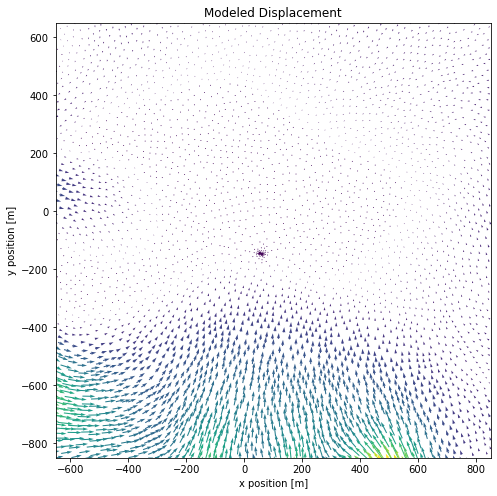

In [28]:
plt.figure(figsize=(8,8))
dl.plot(u)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.title('Modeled Displacement')
plt.xlim(-650,850)
plt.ylim(-850,650)
plt.show()

### Write the displacements to a file

In [29]:
ofile = dl.File("Displacement%s.pvd"%dateStr)
ofile << u

ofile = dl.File("Strain%s.pvd"%dateStr)
ofile << eps

ofile = dl.File("Stress%s.pvd"%dateStr)
ofile << sigma